# Lagrangian-averaged vorticity deviation (LAVD)
In this example, we will compute the Lagrangian-averaged vorticity deviation (LAVD) field for a pitching airfoil.

In [1]:
using ILMPostProcessing
using ViscousFlow
using Plots

# Viscous Flow of Pitching Flat Plate

[ Info: Saved animation to /var/folders/xl/gr8m_0f975dc22nqbqlj0x0c0000gn/T/jl_JS3izU9CTu.gif
109.468679 seconds (39.65 M allocations: 76.375 GiB, 9.97% gc time, 0.11% compilation time)


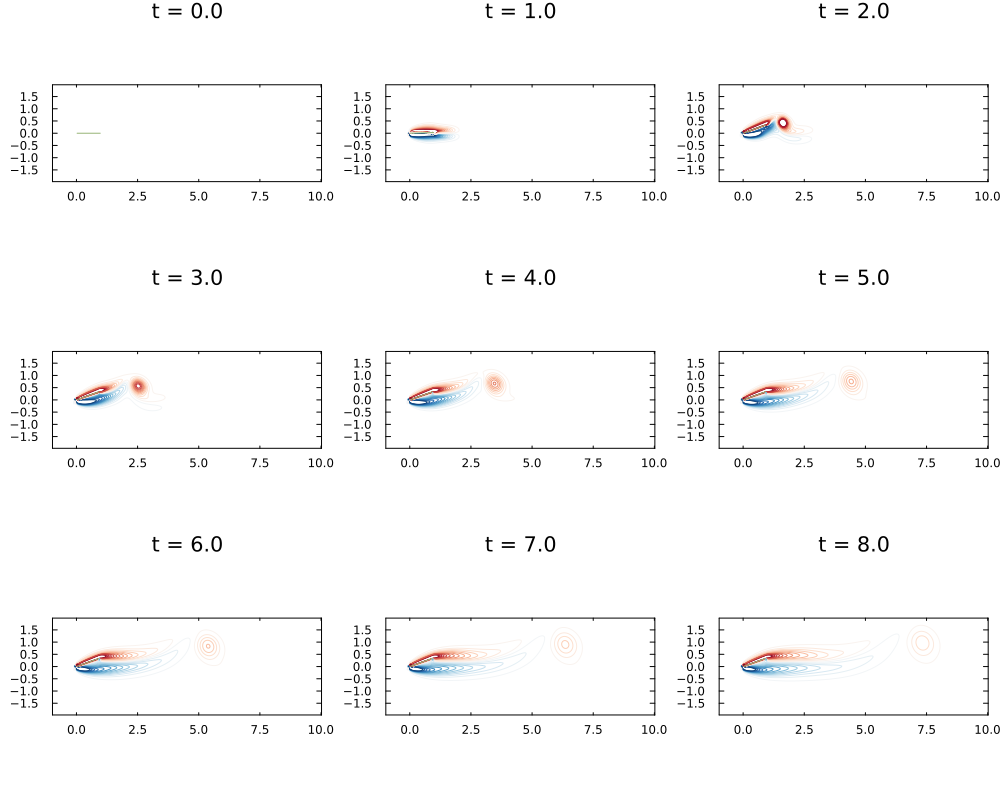

In [2]:
my_params = Dict()
my_params["Re"] = 100
my_params["grid Re"] = 4.0
my_params["freestream speed"] = 1.0
my_params["freestream angle"] = 0.0

xlim = (-1.0,10.0)
ylim = (-2.0,2.0)
g = setup_grid(xlim,ylim,my_params)

Δs = surface_point_spacing(g,my_params)
Lp = 1.0
body = Plate(Lp,Δs)
bl = BodyList([body])

parent_body, child_body = 0, 1
Xp = MotionTransform([0,0],0) # location of joint in inertial system
xpiv = [-0.5,0] # place center of motion at LE
Xc = MotionTransform(xpiv,0)

vel = 1.0  ## nominal ramp velocity
Δx = 20pi/180 ## change in position
t0 = 1.0 ## time of ramp start
k = SmoothRampDOF(vel,Δx,t0)

t = range(0,3,length=301)
plot(t,dof_position.(k.(t)),xlims=(0,Inf),label="x")

joint1 = Joint(RevoluteJoint,parent_body,Xp,child_body,Xc,[k])

m = RigidBodyMotion([joint1],bl)

x = init_motion_state(bl,m)
update_body!(bl,x,m)
plot(bl,xlim=xlim,ylim=ylim)

macro animate_motion(b,m,dt,tmax,xlim,ylim)
    return esc(quote
            bc = deepcopy($b)
            t0, x0 = 0.0, init_motion_state(bc,$m)
            dxdt = zero(x0)
            x = copy(x0)

            @gif for t in t0:$dt:t0+$tmax
                motion_rhs!(dxdt,x,($m,bc),t)
                global x += dxdt*$dt
                update_body!(bc,x,$m)
                plot(bc,xlim=$xlim,ylim=$ylim)
            end every 5
        end)
end

@animate_motion bl m 0.01 4 xlim ylim

function my_vsplus(t,x,base_cache,phys_params,motions)
  vsplus = zeros_surface(base_cache)
  surface_velocity!(vsplus,x,base_cache,motions,t)
  return vsplus
end

function my_vsminus(t,x,base_cache,phys_params,motions)
  vsminus = zeros_surface(base_cache)
  surface_velocity!(vsminus,x,base_cache,motions,t)
  return vsminus
end

bcdict = Dict("exterior" => my_vsplus, "interior" => my_vsminus)

sys = viscousflow_system(g,bl,phys_params=my_params,motions=m,bc=bcdict);
u0 = init_sol(sys)

Umax, imax, tmax, bmax = maxvelocity(u0,sys)
L = Lp
Re_eff = my_params["Re"]*Umax*L

tspan = (0.0,10.0)
integrator = init(u0,tspan,sys,alg=LiskaIFHERK(saddlesolver=CG))

step!(integrator)
@time step!(integrator,8)

sol = integrator.sol
plt = plot(layout = (3,3), size = (1000, 800), legend=:false)
tsnap = 0.0:1.0:8.0
for (i, t) in enumerate(tsnap)
    plot!(plt[i],vorticity(sol,sys,t),sys,layers=false,title="t = $(round(t,digits=2))",clim=(-5,5),levels=range(-5,5,length=30),color = :RdBu)
    plot!(plt[i],surfaces(sol,sys,t))
end
plt

# Compute LAVD

## Generate a Sequence of Velocity and Vorticity Fields
This step obtains the computed velocity and vorticity fields at a sequence of times, and stores them as a sequence of interpolatable
fields. This will greatly speed up how we compute the flow properties (i.e. vorticity) along trajectories.

In [3]:
t_start = 0.0
t_end = 8.0
dt = timestep(u0,sys)
tr = t_start:dt:t_end

velxy = velocity_xy(sol,sys,tr) # Vector of interpolatable velocities
velseq = VectorFieldSequence(tr,velxy); # Bundle together with the time array
vortxy = vorticity_xy(sol,sys,tr)
vortseq = ScalarFieldSequence(tr,vortxy);

## Generate Initial Conditions
Here, we generate a grid of initial locations from which to integrate trajectories.

In [4]:
X_MIN = 1.0
X_MAX = 10.0
Y_MIN = -2.0
Y_MAX = 2.0
dx = 0.01
lavdgrid = PhysicalGrid((X_MIN,X_MAX),(Y_MIN,Y_MAX),dx)
lavd_cache = SurfaceScalarCache(lavdgrid)
x0, y0 = x_grid(lavd_cache), y_grid(lavd_cache)

(CartesianGrids.Primal nodes in a (nx = 924, ny = 405) cell grid of type Float64 data
  Number of CartesianGrids.Primal nodes: (nx = 923, ny = 404), CartesianGrids.Primal nodes in a (nx = 924, ny = 405) cell grid of type Float64 data
  Number of CartesianGrids.Primal nodes: (nx = 923, ny = 404))

## Solve the IVP and Generate LAVD Fields

 14.170086 seconds (7.20 M allocations: 2.098 GiB, 3.70% gc time, 57.35% compilation time)


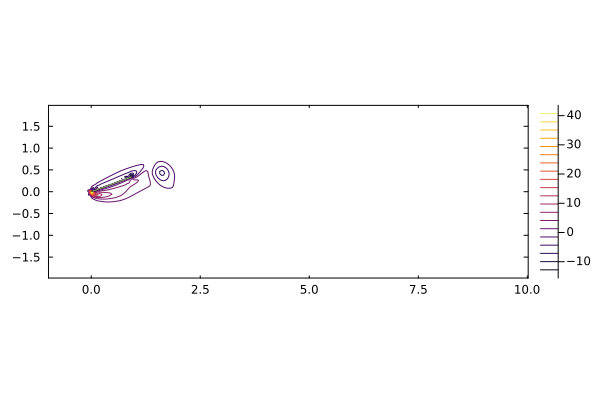

In [5]:
T = 3.0
t0 = 2.0
t1 = t0 + T

@time traj = compute_trajectory(velseq, (x0, y0), (t0, t1))

LAVD = similar(x0)
compute_LAVD!(LAVD, traj, X_MIN, Y_MIN, X_MAX, Y_MAX, vortseq)
plot(LAVD, lavd_cache, colorbar=true, levels  = 10)
plot!(surfaces(sol,sys,t0))

IVD = similar(x0)
compute_IVD!(IVD, traj, X_MIN, Y_MIN, X_MAX, Y_MAX, vortseq)
plot(IVD, lavd_cache, colorbar=true, levels = 10)
plot!(surfaces(sol,sys,t0))

plot(vorticity(sol, sys, t0), sys, levels = 20, colorbar = true)
plot!(surfaces(sol,sys,t0))

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*